# Lab 3: Stochastic Gradient Descent

The goal of this lab session is to code an optimization algorithm that optimzes the penalized loss function of the logistic regression model.

You have to send the filled notebook named **"L3_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com by October 17, 2019. Please put **"AML-L3"** in the subject. 

We begin with the standard imports:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from scipy.linalg import norm
from random import sample 
import random

We import the dataset that we are going to use, an indian dataset including in the last column information about the diabetes status of patients:

In [4]:
from sklearn import model_selection

diabetes_data = pd.read_csv("w8a.csv", sep=";", header=None)


X=diabetes_data.iloc[:, :-1].to_numpy()
y=diabetes_data.iloc[:, -1].to_numpy()

X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y, test_size=0.33, random_state=42)

## Logistic Regression



Today we’ll be moving from linear regression to logistic regression, one of the simplest ways to deal with a classification problem. Instead of fitting a line, logistic regression models the probability that the outcome is 1 given the value of the predictor. In order to do this we need a function that transforms our predictor variable to a value between 0 and 1. Lots of functions can do that, but the logistic function is the most common choice:

$$f(z) = \frac{1}{1+\exp{-z}}.$$

To predict the class of our observations we'll have to minimize the corresponding loss function and as we are in a high-dimensional context we'll add an $l_2$ regularization to the model:

$$L(\textbf{w}) = \sum_{i=1}^n log(1+\exp(-y_i\textbf{w}^Tx_i))+\frac{\lambda}{2} \| \textbf{w} \|^2,$$

where $x_i$ is the vector of features for the observation $i$ and $y_i \in \{-1, 1\}$ is the class label.  


We first use the `sklearn` implementation:

In [5]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty="l2", C=2) 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

and we compute the accuracy score to evaluate the model performance:

In [6]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.985320989158241

### Assignment

Implement from scratch your own logistic regression model with stochastic gradient descent optimization. 

- Fill in the class

- Display the evolution of the cost function along iterations. Do this for several strategies for the setting of the learning rate

- Try the different acceleration strategies

- Train the model with the training set and evaluate its performance in the test set

In [20]:
class StochasticLogisticRegression():
    """ Class for logistic regression:
    
    Attributes:
    -----------
    coef_: 1-dimensional np.array
        coefficients 
    alpha_: float
        regularization parameter
    lr_: float
        the learning rate
    bsize: integer
        the size of the mini-batch >=1
    coef_history_: list
        the list of all visited betas
    f_history_: list 
        the list of all evaluations in visited betas
        
    method : string , 
        iterative  method of optimisation, can be adam or sgd. 
    """
    def __init__(self , lr= 1e-2 , gamma = 0.9 , beta= 0.999 , max_iter = 100 ,
                  alpha=0., batch_size= 256 , eps= 1e-10 , debias=False , method = "adam"):
        self.coef_  = None
        self.alpha_ = alpha
        self.gamma_ = gamma
        self.beta_  = beta
        self.max_iter_ = max_iter
        self.eps_    = eps 
        self.lr_     = lr
        self.bsize_  = batch_size
        self.debias_ = debias
        self.coef_history_ = []
        self.f_history_ = []
        self.all_iters_ = []
        self.method=method
        
    def fit(self, X, y):
        """ Fit the data (X, y).
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        y: (num_sampes, ) np.array
            Output vector
        
        Note:
        -----
        Updates self.coef_
        """    
        def compute_loss(X_,y_):
            """
            Compute the logistic loss over all observations.
            """
            
            reg=self.alpha_ * (norm(self.coef_)**2)
            L=np.sum([np.log(1+np.exp(- y_[i] * self.coef_.T @ X_[i] )) for i in range(len(X_))]) + reg
            return L
            
        def compute_grad (X_batch,y_batch):
            """
            Compute a minibatch gradient.
            """
            grad= - np.sum([y_batch[i] * sigmoid (- y_batch[i] * self.coef_.T @ X_batch[i]) for i in range(len(X_batch))])+ \
                            self.alpha_ * self.coef_ 
            return grad
            
            
        def sigmoid (x) :
            return 1/(1 + np.exp(-x))
        
        # X_aug : add columns of ones to X
        n_samples,n_features= X.shape
        X_aug=np.ones((n_samples,n_features+1))
        X_aug[:,1:]=X
    
        
        # We initialize coefficients from the normal distribution , we take a standard deviation relatively small
        # to avoid gradient explosion and overfitting . 
        self.coef_=np.random.normal(0, 0.1, n_features+1) 
        self.coef_history_=[self.coef_]
        
        if self.method=="adam" :
            tab_m=[np.zeros((n_features+1,))]
            tab_s=[np.ones((n_features+1,))]
        
        
        n_iter, all_iters=1,[]
        while n_iter < self.max_iter_ : 
            ## Select batch sample 
            indexes_sample=sample(list(range(len(X_aug))),self.bsize_)
            X_batch=X_aug[indexes_sample]
            y_batch=y[indexes_sample]
            
            ## grad 
            grad = compute_grad(X_batch,y_batch)
            
            ## gradient descent 
            if self.method=="adam" :
                if self.debias_ :
                    coef_m = 1/(1- self.beta_ ** n_iter )
                    coef_s = 1/(1- self.gamma_ ** n_iter)
                else : 
                    coef_m = 1
                    coef_s = 1

                new_m = coef_m * ( self.beta_ * tab_m[-1] + (1-self.beta_) * grad)
                new_s = coef_s * ( self.gamma_ * tab_s[-1] + (1-self.gamma_) * (grad**2)) 

                tab_m.append (new_m)
                tab_s.append (new_s)
            
                ## update weights 
                self.coef_-= (self.lr_ / (np.sqrt(new_s) + self.eps_) ) * new_m
            else : 
                self.coef_-= self.lr_  * grad
            
            self.coef_history_.append(self.coef_)
            self.f_history_.append(compute_loss(X_aug,y_train))
            self.all_iters_.append(n_iter)
            
            n_iter+=1
        
        
  
    def predict(self, X):
        """ Make binary predictions for data X.
    
        Parameters:
        -----------
        X: (num_samples, num_features) np.array
            Design matrix
        
        Returns:
        -----
        y_pred: (num_samples, ) np.array
            Predictions (0 or 1)
        """
        
        n_samples,n_features= X.shape
        X_aug=np.ones((n_samples,n_features+1))
        
        X_aug[:,1:]=X
        
        
        prob_class_1 = np.exp(X_aug @ self.coef_) / (1 + np.exp(X_aug @ self.coef_))
        y_pred = [ 1 if prob >0.5 else  -1 for prob in prob_class_1 ]
        
        return y_pred



Apply to the data

In [17]:
model = StochasticLogisticRegression (max_iter= 200 , debias=False ,  batch_size=len(X_train))
model.fit( X_train, y_train )

## Predict on test 

In [18]:
y_pred=model.predict(X_test)
print('The accuracy is : ', accuracy_score(y_test, y_pred) ) 

The accuracy is :  0.9696674381776099


### Remarks :  
* We obtain a score of 97% if we use adam algorithm, the parameters are (lr= 1e-2 , gamma = 0.9 , beta= 0.999 , max_iter = 200 , alpha=0., batch_size= len(X_train) , eps= 1e-10 , debias=False ). This score can be misleading since we have a problem of unbalanced classes. A more adapted metric can be the F1 - score which accounts for precision and recall values.
* I chose debiasing = False to prevent gradient explosion. In fact the terms in beta ** t and gamma ** t are important in the first iterations , so the norm of the gradients and therefore the weights increases rapidly. 

# Effects of the hyperparameters 

### Beta effect 

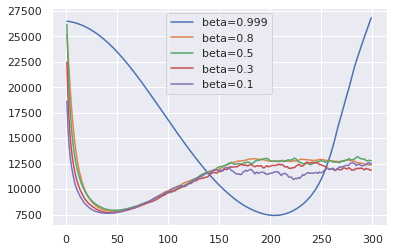

In [190]:
tab_betas = [0.999, 0.8 , 0.5 , 0.3 , 0.1]

for beta in tab_betas :
    model = StochasticLogisticRegression ( max_iter=300 , beta=beta)
    model.fit (X_train, y_train  )
    losses_,iters_=model.f_history_,model.all_iters_
    plt.plot(iters_,losses_, label='beta={}'.format(beta))

plt.legend()
plt.show()    
    
    

For beta = 0.999 , we obtain a minimum slightly lower than the others. But the convergence is much slower for Beta =0.999 . So choosing a value of 0.1 might be better . This means that we give more weight to the current gradient than the previous momentums . The smaller value of beta obtained can also be due to the fact that we don't apply debiasing.

## gamma effect

We constrain the number of iterations to 200 with a batch size of 256.

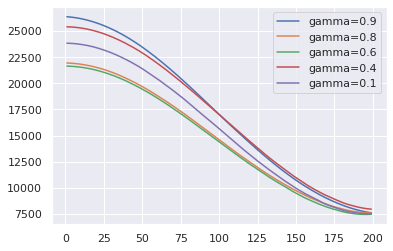

In [192]:
tab_gammas = [0.9, 0.8, 0.6, 0.4 , 0.1]

for gamma in tab_gammas :
    model = StochasticLogisticRegression ( max_iter=200, gamma=gamma)
    model.fit( X_train , y_train )
    losses_,iters_=model.f_history_,model.all_iters_
    plt.plot(iters_, losses_, label='gamma={}'.format(gamma))

plt.legend()
plt.show()    
    

Here again, a high value of gamma might not be optimal. From the graph we can se that a value of 0.6 can be good. 

## Learning rate effect 

/home/hamza/.local/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


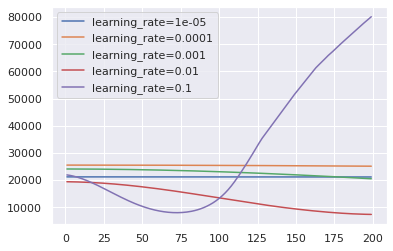

In [7]:
tab_lr = [1e-5,1e-4,1e-3,1e-2,0.1]

for lr in tab_lr :
    model = StochasticLogisticRegression ( max_iter=200, lr=lr)
    model.fit( X_train , y_train )
    losses_,iters_=model.f_history_,model.all_iters_
    plt.plot(iters_, losses_, label='learning_rate={}'.format(lr))

plt.legend()
plt.show()    

For a very slow learning rate ( 1e-5, 1e-4) , The loss function didn't decrease through iterations , or it decreased slowly. For a very high learning rate , the algorithm converged quickly until the loss function reached its minimum but than increased for the next iterations. 
Therefore , an optimal value for our problem is lr = 1e-2 . A solution to the problem of the " gradient escaping " ( when the loss function increases after the minimum ) may be to use another stopping criterion , such as the norm of the gradient is less than a certain epsilon, or more sophistically , for non convex objective functions , we can use early stopping on certain validation data . 

## Comparing sgd and adam 
We compare the two methods by comparing their convergence speed for different values of learning rate. 

/home/hamza/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in exp
/home/hamza/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in exp


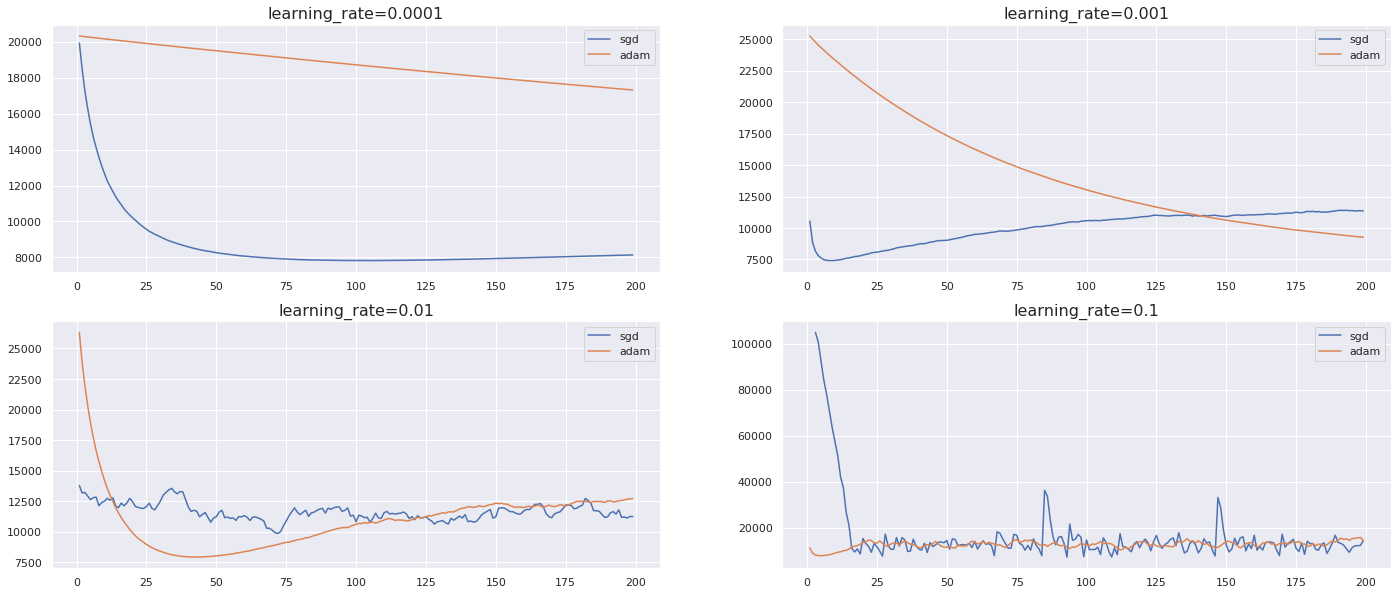

In [27]:
tab_lr = [1e-4,1e-3,1e-2,0.1]
fig, ax = plt.subplots(2, 2, figsize=(24, 10))

tab_k_j=[[0,0],[0,1],[1,0],[1,1]]
for i,lr in enumerate(tab_lr) :
    k,j=tab_k_j[i]
    
    model_sgd = StochasticLogisticRegression ( max_iter=200, lr=lr,method='sgd')
    model_sgd.fit( X_train , y_train )
    losses_sgd,iters_sgd=model_sgd.f_history_,model_sgd.all_iters_
    
    model_adam = StochasticLogisticRegression (max_iter=200, lr=lr , beta = 0.1 , gamma=0.6 ) 
    model_adam.fit( X_train , y_train )
    losses_adam,iters_adam=model_adam.f_history_,model_adam.all_iters_
    
    ax[k][j].plot(iters_sgd, losses_sgd, label='sgd')
    ax[k][j].plot(iters_adam, losses_adam, label='adam')
    ax[k][j].set_title('learning_rate={}'.format(lr), size=16)
    ax[k][j].legend()
    
plt.show()   

For a learning rate of 1e-5, The SGD algorithm is better than adam. In fact , taking into account the momentums of the previous steps for such a small learning rate slowes drastically the convergence of the algorithm.
For lr = 0.001 , we have the best performance of sgd algorithm : the loss function reaches its minimum within a few iterations. 
For lr =0.01 , Adam algorithm is better but the attained minimum is slightly worse than the one obtained by sgd for a learning rate of 0.001 . Furthermore, we observe oscillations for sgd algorithm . 
Therefore , SGD is overall better and faster than adam . The explanation of this behaviour can be :
* We may find correlations simply by sgd algorithm without using adam. In fact our features are zero or one. So SGD algorithm may be enough to converge rapidly towards the minimum of f . Plus we have an important number of samples to train on . 
* The chosen parameters of Adam might not be well adapted. Furthermore , we chose debiasing =False to prevent the exploding gradient , which may not be optimal for the convergence speed. So initializing the weights with more sophisticated algorithms (He, Xavier ... ) may enable us to use the debiasing and improve our algorithm. 
* Reaching a minimum for the training set does not guarantee an optimal generalization. So checking the performance on validation set might also be intersting to compare both algorithms.